In [8]:
import pandas as pd
import os
from scipy import signal

import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, BatchNormalization, MaxPooling2D # tf2.0 MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.python.keras.callbacks import TensorBoard
from time import time
import random

## Reading files and re-exploring new-shaped spectrograms 

In [26]:
labels_dirs_path = '../data/osc_data/'
labels_dirs = next(os.walk(labels_dirs_path))[1]
label_dir = labels_dirs[0]
label_dir_path = '../data/osc_data/' + label_dir
label_files = next(os.walk(label_dir_path))[2]
label_file = label_files[0]
lbl_file_df = pd.read_csv(label_dir_path + '/' + label_file, sep=',')

In [27]:
lbl_file_df.head()

,ch1,ch2,ch3,ch4
0,-33.99,-541.97,-71.61,60.61
1,-22.28,-473.96,-125.56,28.82
2,5.73,-338.79,-130.38,-5.43
3,-25.76,-507.57,-119.21,20.62
4,7.00,-432.08,-115.92,14.51


## Alpha label

label: right
file: jose_1_right_8_14.csv
spec_shape: (6, 21)
frequencies_shape: (6,)
times_shape: (21,)


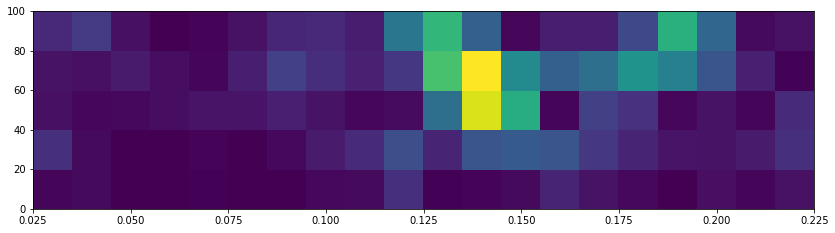

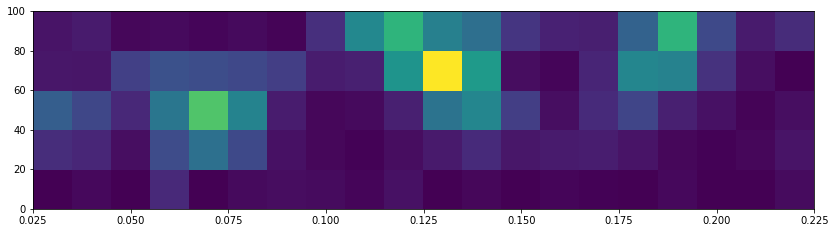

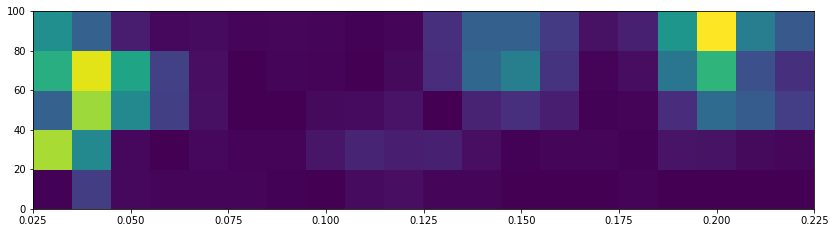

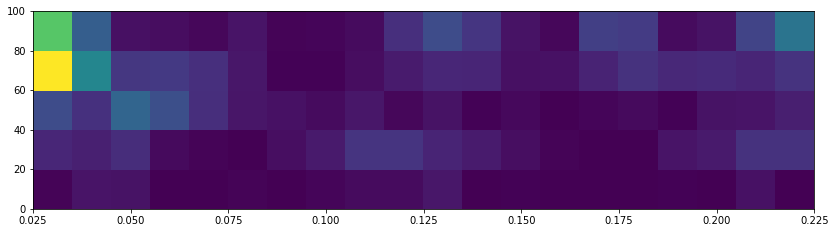

In [34]:
lbl_dir = labels_dirs[0]
label_dir_path = '../data/osc_data/' + label_dir
label_files = next(os.walk(label_dir_path))[2]
file = random.choice(label_files)
file_on = pd.read_csv(label_dir_path + '/' + file, sep=',')

#Spectrogram hyperparameters
nperseg=10 #increasing nperseg increases frequency resolution and decreases time res
noverlap=8 #increasing time resolution requires increasing overlap
window = 'hann' #hann provides good time and frequency resolution properties

#Spectrogram
frequencies, times, spec = signal.spectrogram(x=file_on['ch1'],
                                              fs=200, nperseg=nperseg,
                                              noverlap=noverlap, window=window)

#Subplot 1
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Subplot 2
frequencies, times, spec = signal.spectrogram(x=file_on['ch2'], fs=200, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Subplot 3
frequencies, times, spec = signal.spectrogram(x=file_on['ch3'], fs=200, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Subplot 4
frequencies, times, spec = signal.spectrogram(x=file_on['ch4'], fs=200, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Specs and Shapes
print('label:', label_dir)
print('file:', file)
print('spec_shape:', spec.shape)
print('frequencies_shape:', frequencies.shape)
print('times_shape:', times.shape)

## Random label

label: right
file: jose_2_right_1_23.csv
spec_shape: (6, 21)
frequencies_shape: (6,)
times_shape: (21,)


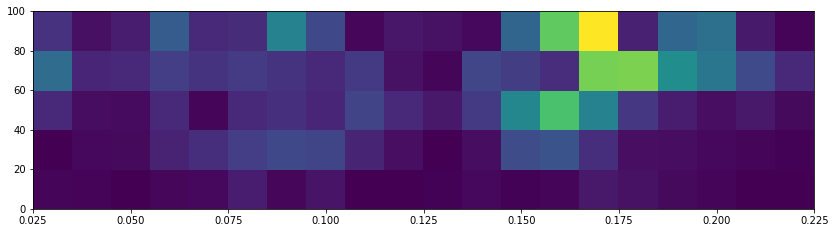

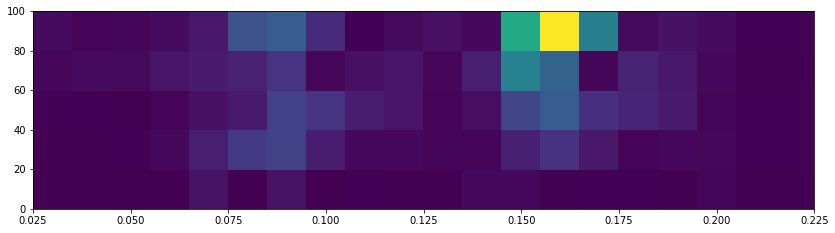

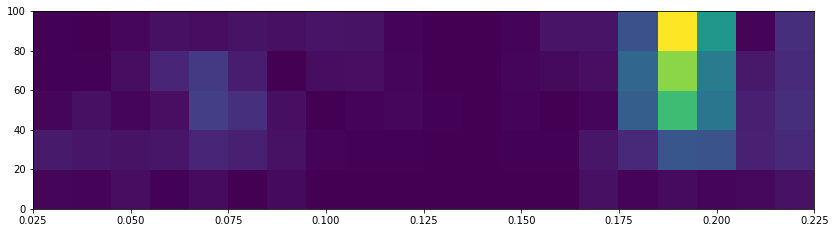

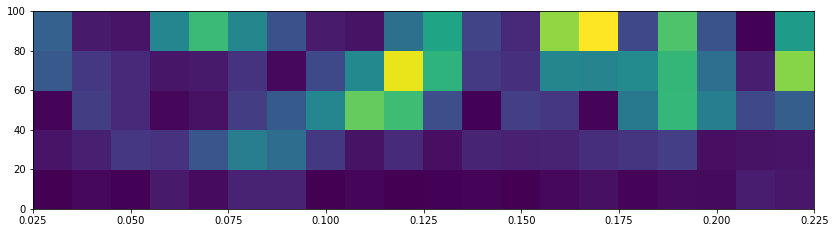

In [32]:
#Label and file selection
label_dir = random.choice(labels_dirs)
label_dir_path = '../data/osc_data/' + label_dir
label_files = next(os.walk(label_dir_path))[2]
file = random.choice(label_files)
file_on = pd.read_csv(label_dir_path + '/' + file, sep=',')

#Spectrogram hyperparameters
nperseg=10 #increasing nperseg increases frequency resolution and decreases time res
noverlap=8 #increasing time resolution requires increasing overlap
window = 'hann' #hann provides good time and frequency resolution properties

#Spectrogram
frequencies, times, spec = signal.spectrogram(x=file_on['ch1'],
                                              fs=200, nperseg=nperseg,
                                              noverlap=noverlap, window=window)

#Subplot 1
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Subplot 2
frequencies, times, spec = signal.spectrogram(x=file_on['ch2'], fs=200, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Subplot 3
frequencies, times, spec = signal.spectrogram(x=file_on['ch3'], fs=200, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Subplot 4
frequencies, times, spec = signal.spectrogram(x=file_on['ch4'], fs=200, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Specs and Shapes
print('label:', label_dir)
print('file:', file)
print('spec_shape:', spec.shape)
print('frequencies_shape:', frequencies.shape)
print('times_shape:', times.shape)

# Model

### Globals

In [36]:
###
labels_dirs_path = '../data/osc_data/'
labels_dirs = next(os.walk(labels_dirs_path))[1]
channels = ['ch1', 'ch2', 'ch3', 'ch4']

###
shape = (6, 21, 4)
flat_dim = shape[0]*shape[1]*shape[2]
nperseg = 10
noverlap = 8
reshape = (-1, shape[0], shape[1], shape[2])
j = 0
i = 0
dir_num = 0
df_train_g = pd.DataFrame()

## Read data to create dataframe with spectograms

In [38]:
for lbl_dir in labels_dirs:
    filepath = os.path.join(labels_dirs_path, lbl_dir)
    files = next(os.walk(filepath))[2]
    num_examples = len(files)
    x_shape = (num_examples, 6, 21, 4)
    x1_train = np.zeros(x_shape)
    j = 0
    for filename in files:
        file = pd.read_csv(os.path.join(labels_dirs_path, lbl_dir, filename), sep=',')
        img = np.zeros(shape)
        k = 0
        for i in range(4):
            frequencies, times, spec = signal.spectrogram(x=file[channels[i]], fs=200,
                                                          nperseg=nperseg, noverlap=noverlap,
                                                          window='hann')
            log_spec = np.log(spec)
            img[:,:,i] = spec
            i = i + 1
        x1_train[j,:,:,:] = img
        j = j + 1
    print(lbl_dir, x1_train.shape)
    flat = np.reshape(x1_train, (num_examples, flat_dim))
    df_train1 = pd.DataFrame(data=flat)
    vals = np.array([dir_num] * num_examples)
    dir_num = dir_num + 1
    df_train1['label'] = vals
    df_train_g = df_train_g.append(df_train1, ignore_index=True)

alpha (1160, 6, 21, 4)
right (1080, 6, 21, 4)
stop (1160, 6, 21, 4)
omega (1160, 6, 21, 4)
go (1120, 6, 21, 4)
left (1120, 6, 21, 4)
neutral (1040, 6, 21, 4)


In [32]:
df_train_g.head()

,0,1,2,3,4,5,6,7,8,9,...,495,496,497,498,499,500,501,502,503,label
0,0.269763,0.000007,2.690894,0.285193,4.696668,26.142539,5.916528,5.797650,1.394728,1.576310,...,3.841037,3.091718,16.319097,1.561007,2.145334,1.286712,6.197624,0.272434,0.917669,0
1,0.762344,0.009737,0.354214,0.000517,0.203516,0.193552,0.906154,0.016050,1.219763,1.619854,...,0.233409,0.711764,0.001415,5.419373,1.753770,2.752352,12.246400,8.266206,0.920694,0
2,0.012787,1.610314,0.105238,0.023809,0.747766,0.020359,6.185523,0.869656,0.088764,0.037561,...,0.000238,0.000509,0.956125,1.155039,0.029721,1.450493,0.545698,8.199032,0.078900,0
3,3.198062,1.395169,3.978304,0.476088,0.032568,0.091444,0.021168,0.076012,0.049189,5.689870,...,0.254437,1.999421,100.944967,0.311347,0.118430,1.928447,118.050244,0.869525,0.702323,0
4,1.832447,0.254555,0.309685,0.020131,3.494906,7.610915,1.930834,0.832520,0.342319,3.308603,...,0.033883,0.010655,0.000876,3.320260,0.008457,0.002498,0.364157,0.591829,0.008037,0


In [46]:
def preprocess_features(x_train):
    x_train = x_train.replace(-np.inf, 0)
    x_train = np.log(x_train.values)
    x_train_norm = x_train.reshape(reshape)
    return x_train_norm

In [47]:
def preprocess_targets(y_train):
    y_train_hot = tf.keras.utils.to_categorical(y_train, num_classes=7)
    return y_train_hot

In [48]:
int(df_train_g.shape[0]*.8)

6272

In [49]:
df_train_g = df_train_g.reindex(np.random.permutation(df_train_g.index))
X_train = preprocess_features(df_train_g.drop(labels = ['label'], axis = 1).head(int(df_train_g.shape[0]*.8)).copy())
X_test = preprocess_features(df_train_g.drop(labels = ['label'], axis = 1).tail(int(df_train_g.shape[0]*.2)).copy())
Y_train = preprocess_targets(df_train_g['label'].head(int(df_train_g.shape[0]*.8)).copy())
Y_test = preprocess_targets(df_train_g['label'].tail(int(df_train_g.shape[0]*.2)).copy())

In [50]:
df_train_g.head()

,0,1,2,3,4,5,6,7,8,9,...,495,496,497,498,499,500,501,502,503,label
880,0.000778,13.056984,12.864079,0.045172,0.053630,2.722141,0.229924,0.038204,0.180067,0.197377,...,0.081307,0.105847,42.117750,11.564205,0.002161,0.091776,52.272398,1.009657,0.063984,0
57,1.680988,15.463871,1.059413,0.187840,0.020906,0.067087,15.271583,0.475838,2.612971,3.556246,...,1.730422,0.670285,38.211534,17.336277,4.829449,0.404895,12.411689,68.423026,7.746044,0
5098,0.007663,1.384460,13.198671,2.827051,1.300103,1.437081,1.296159,3.337062,0.002369,0.169161,...,2.342641,0.080910,3.612984,0.736218,1.051325,0.025900,16.738387,0.001273,0.093787,4
3965,0.000326,6.176543,0.082022,0.004246,4.612829,9.343383,0.000782,0.000185,2.775274,0.529789,...,0.818439,309.786684,57.689673,0.165509,0.837427,236.739779,184.943256,0.072622,0.398559,3
4912,0.218023,3.701561,0.009005,3.094049,0.037662,0.925011,0.030804,0.807759,0.081063,0.829810,...,4.387835,0.588907,0.302893,2.970162,1.009957,0.417789,3.235651,0.608810,0.636877,4


In [51]:
X_train.shape

(6272, 6, 21, 4)

In [52]:
def create_model(input_shape):
    inputlayer = Input(shape=input_shape)
    nclass = 7
    
    norm_input = BatchNormalization()(inputlayer)
    model = Conv2D(32, kernel_size=2, padding='same', activation='relu')(norm_input)
    model = Conv2D(32, kernel_size=2, padding='same', activation='relu')(model)
    model = MaxPooling2D(pool_size=(2, 2))(model)
    model = Dropout(rate=0.2)(model)
    model = Conv2D(64, kernel_size=3, padding='same', activation='relu')(model)
    model = Conv2D(64, kernel_size=3, padding='same', activation='relu')(model)
    model = MaxPooling2D(pool_size=(2, 2))(model)
    model = Dropout(rate=0.2)(model)
    model = Conv2D(128, kernel_size=3, padding='same', activation='relu')(model)
    model = Conv2D(128, kernel_size=3, padding='same', activation='relu')(model)
    model = MaxPooling2D(pool_size=(1, 1))(model)
#    model = Dropout(rate=0.2)(model)
#    model = Conv2D(256, kernel_size=2, padding='same', activation='relu')(model)
#    model = Conv2D(256, kernel_size=2, padding='same', activation='relu')(model)
#    model = MaxPooling2D(pool_size=(1, 1))(model)
#    model = Dropout(rate=0.2)(model)
#    model = Conv2D(512, kernel_size=2, padding='same', activation='relu')(model)
#    model = Conv2D(512, kernel_size=2, padding='same', activation='relu')(model)
#    model = MaxPooling2D(pool_size=(1, 1))(model)
    model = Flatten()(model) 

    dense_1 = BatchNormalization()(Dense(128, activation='relu')(model))
    dense_1 = BatchNormalization()(Dense(128, activation='relu')(dense_1))
    dense_1 = Dense(nclass, activation='softmax')(dense_1)

    model = Model(inputs=inputlayer, outputs=dense_1)
    
    return model

In [53]:
model3 = create_model(shape)

In [54]:
print(model3.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6, 21, 4)]        0         
_________________________________________________________________
batch_normalization_v2_3 (Ba (None, 6, 21, 4)          16        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 21, 32)         544       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 21, 32)         4128      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 10, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 10, 32)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 10, 64)         1849

In [65]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0001,
                                   beta_1 = 0.9,
                                   beta_2 = 0.999,
                                   epsilon = 1e-08)

In [66]:
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
tensorboard = TensorBoard(log_dir='./logs/{}'.format(time()))

In [68]:
Y_train.shape

(6272, 7)

In [69]:
history = model3.fit(X_train,
                   Y_train,
                   batch_size=50,
                   epochs=30,
                   validation_split=0.1,
                   callbacks=[tensorboard])

Train on 5644 samples, validate on 628 samples
Epoch 1/30
5644/5644 [==============================] - 4s 688us/sample - loss: 0.2402 - accuracy: 0.9057 - val_loss: 0.2747 - val_accuracy: 0.9013
Epoch 2/30
5644/5644 [==============================] - 3s 493us/sample - loss: 0.2266 - accuracy: 0.9125 - val_loss: 0.2385 - val_accuracy: 0.8981
Epoch 3/30
5644/5644 [==============================] - 3s 495us/sample - loss: 0.2266 - accuracy: 0.9180 - val_loss: 0.2496 - val_accuracy: 0.8981
Epoch 4/30
5644/5644 [==============================] - 3s 488us/sample - loss: 0.2217 - accuracy: 0.9167 - val_loss: 0.2351 - val_accuracy: 0.9076
Epoch 5/30
5644/5644 [==============================] - 3s 491us/sample - loss: 0.2122 - accuracy: 0.9176 - val_loss: 0.2308 - val_accuracy: 0.9076
Epoch 6/30
5644/5644 [==============================] - 3s 505us/sample - loss: 0.2144 - accuracy: 0.9153 - val_loss: 0.3075 - val_accuracy: 0.8933
Epoch 7/30
5644/5644 [==============================] - 3s 497us/

In [70]:
preds = model3.predict(X_test)

In [71]:
preds[0]

array([3.5354060e-03, 4.4036643e-03, 1.0686202e-03, 9.3984801e-01,
       5.8285572e-04, 5.0046552e-02, 5.1492709e-04], dtype=float32)

#### Evaluate accuracy on never before seen data

In [72]:
evaluate = model3.evaluate(X_test, Y_test)

1568/1568 [==============================] - 0s 139us/sample - loss: 0.2728 - accuracy: 0.9171


#### Save model

In [ ]:
model3.save('model_3.h5')